In [233]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import argparse
import os
from pathlib import Path
import json
import re
import numpy as np
import importlib
from typing import Callable, Any
OUTPUT_DIR = "graficos"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
def _load_from_modules(package: str, attribute_name: str, filter_func: Callable[[Any], bool] = lambda x: True):
    result = {}
    package_path = package.replace('.', '/')

    for file in os.listdir(package_path):
        if file.endswith('.py') and not file.startswith('__'):
            module_name = file[:-3]
            full_module_name = f"{package}.{module_name}"
            module = importlib.import_module(full_module_name)

            attr = getattr(module, attribute_name, None)
            if attr is not None and filter_func(attr):
                result[module_name] = attr

    return result

def load_algorithms(package: str):
    return _load_from_modules(package, "ALGORITHMS")

In [235]:
def ensure_output_dir(output_dir):
    """
    Checks if OUTPUT_DIR exists, and creates it if not.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    else:
        print(f"Directory already exists: {output_dir}")

ensure_output_dir(OUTPUT_DIR)

Directory already exists: graficos


In [236]:
def find_csv_recursive(root_dir, filename):
    """
    Recursively search for a file named `filename` in `root_dir`.
    Returns the full path if found, else None.
    """
    for dirpath, _, files in os.walk(root_dir):
        if filename in files:
            return os.path.join(dirpath, filename)
    return None

def load_results(input_dir,  index_col="variant"):
    """
    Loads CSV data from each subdirectory in input_dir.
    Returns a dictionary:
    {
        'subdir_name': {
            'time-evaluation-tmean-std': pd.DataFrame,
            'blocksim-mean-std': pd.DataFrame
        },
        ...
    }
    """
    results = {}
    for subdir in os.listdir(input_dir):
        subdir_path = os.path.join(input_dir, subdir)
        if os.path.isdir(subdir_path):
            data = {}
            for key in ['time-evaluation-mean-std', 'blocksim-mean-std']:
                csv_path = find_csv_recursive(subdir_path, f"{key}.csv")
                if csv_path:
                    data[key] = pd.read_csv(csv_path, index_col=index_col)
                else:
                    data[key] = None  # or pd.DataFrame() if preferred
            results[subdir] = data
    return results

results = load_results("resultados-artigo")
print(results)  # Print the keys to verify loading

{'m1': {'time-evaluation-mean-std':                             mean_keypair  std_keypair   mean_sign  std_sign  \
variant                                                                       
Falcon-1024                    13.815199     3.629597    0.334238  0.002395   
Falcon-512                      4.672339     1.223782    0.168685  0.001740   
MAYO-2                          0.023650     0.000470    0.056167  0.000736   
MAYO-3                          0.041937     0.000738    0.149392  0.001252   
MAYO-5                          0.090139     0.000961    0.283957  0.001815   
ML-DSA-44                       0.023373     0.000568    0.055099  0.029951   
ML-DSA-65                       0.038736     0.000714    0.087051  0.047444   
ML-DSA-87                       0.060399     0.000863    0.108518  0.046810   
P-256                           0.015014     0.000645    0.032926  0.000960   
P-384                           0.122927     0.001743    0.200575  0.002112   
P-521           

In [237]:
def get_variants_by_level(df, variant_dict):
    csv_variants = set(df.index.to_list())
    print("CSV Variants:", csv_variants)
    variants_by_level = {}

    for algorithm, levels in variant_dict.items():
        for level, variant in levels.items():
            if variant in csv_variants:
                variants_by_level.setdefault(level, []).append({
                    "algorithm": algorithm,
                    "variant": variant
                })
             
    return dict(sorted(variants_by_level.items()))

def filter_algorithms(algorithms: dict, selected_algorithms: list = None, selected_levels: list = None) -> dict:
    selected_algorithms = selected_algorithms or []
    selected_levels = selected_levels or []

    filtered = {}

    for module, algos in algorithms.items():
        for algorithm, variants in algos.items():
            if selected_algorithms and algorithm not in selected_algorithms:
                continue

            selected_variants = {
                level: name for level, name in variants.items()
                if not selected_levels or level in selected_levels
            }

            if selected_variants:
                filtered.setdefault(module, {})[algorithm] = selected_variants

    return filtered


All algorithms loaded: ['cryptography', 'liboqs']
Filtered algorithms: {'cryptography': {'ecdsa': {1: 'P-256', 3: 'P-384', 5: 'P-521'}}, 'liboqs': {'mldsa': {1: 'ML-DSA-44', 3: 'ML-DSA-65', 5: 'ML-DSA-87'}, 'mayo': {1: 'MAYO-2', 3: 'MAYO-3', 5: 'MAYO-5'}}}
Combined mechanisms: {'ecdsa': {1: 'P-256', 3: 'P-384', 5: 'P-521'}, 'mldsa': {1: 'ML-DSA-44', 3: 'ML-DSA-65', 5: 'ML-DSA-87'}, 'mayo': {1: 'MAYO-2', 3: 'MAYO-3', 5: 'MAYO-5'}}
CSV Variants: {'SPHINCS+-SHA2-256f-simple', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-192s-simple', 'cross-rsdp-128-balanced', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-128-fast', 'cross-rsdp-256-balanced', 'ML-DSA-87', 'MAYO-5', 'P-521', 'MAYO-2', 'SPHINCS+-SHAKE-128f-simple', 'MAYO-3', 'cross-rsdpg-256-balanced', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdp-128-small', 'Falcon-1024', 'Falcon-512', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdpg-256-small', 'ML-DSA-65', 'SPHINCS+-SHA2-128f-simple', 'cross-rsdpg-192-small', 'cross-rsdp-192-small', 'P-384', 'cross-rs

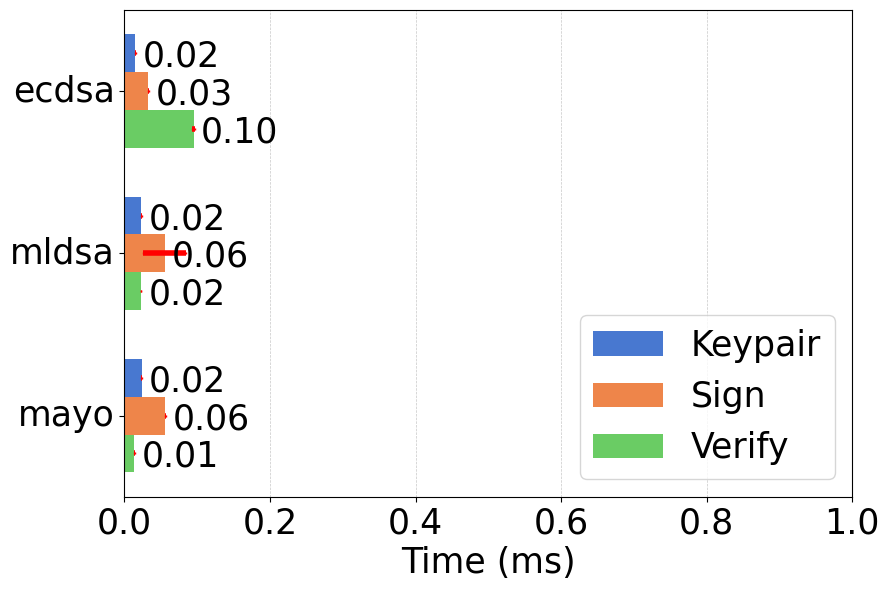

	Processing level 3 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-384'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-65'}, {'algorithm': 'mayo', 'variant': 'MAYO-3'}]
Variant to Algorithm mapping: {'P-384': 'ecdsa', 'ML-DSA-65': 'mldsa', 'MAYO-3': 'mayo'}

DataFrame with algorithm column:
            mean_keypair  std_keypair  mean_sign  std_sign  mean_verify  \
variant                                                                  
MAYO-3         0.041937     0.000738   0.149392  0.001252     0.048730   
ML-DSA-65      0.038736     0.000714   0.087051  0.047444     0.037148   
P-384          0.122927     0.001743   0.200575  0.002112     0.603138   

           std_verify algorithm          algorithm2  
variant                                              
MAYO-3       0.001195      mayo      mayo\n(MAYO-3)  
ML-DSA-65    0.000687     mldsa  mldsa\n(ML-DSA-65)  
P-384        0.003315     ecdsa      ecdsa\n(P-384)  
graficos/m1_level-3.pdf


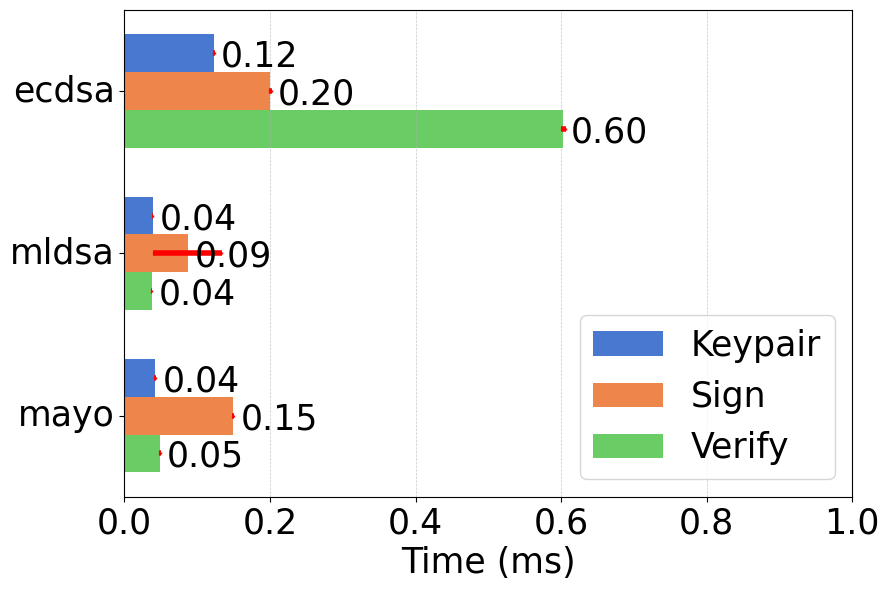

	Processing level 5 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-521'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-87'}, {'algorithm': 'mayo', 'variant': 'MAYO-5'}]
Variant to Algorithm mapping: {'P-521': 'ecdsa', 'ML-DSA-87': 'mldsa', 'MAYO-5': 'mayo'}

DataFrame with algorithm column:
            mean_keypair  std_keypair  mean_sign  std_sign  mean_verify  \
variant                                                                  
MAYO-5         0.090139     0.000961   0.283957  0.001815     0.093001   
ML-DSA-87      0.060399     0.000863   0.108518  0.046810     0.058356   
P-521          0.109645     0.001459   0.225384  0.002237     0.620297   

           std_verify algorithm          algorithm2  
variant                                              
MAYO-5       0.001022      mayo      mayo\n(MAYO-5)  
ML-DSA-87    0.001054     mldsa  mldsa\n(ML-DSA-87)  
P-521        0.003436     ecdsa      ecdsa\n(P-521)  
graficos/m1_level-5.pdf


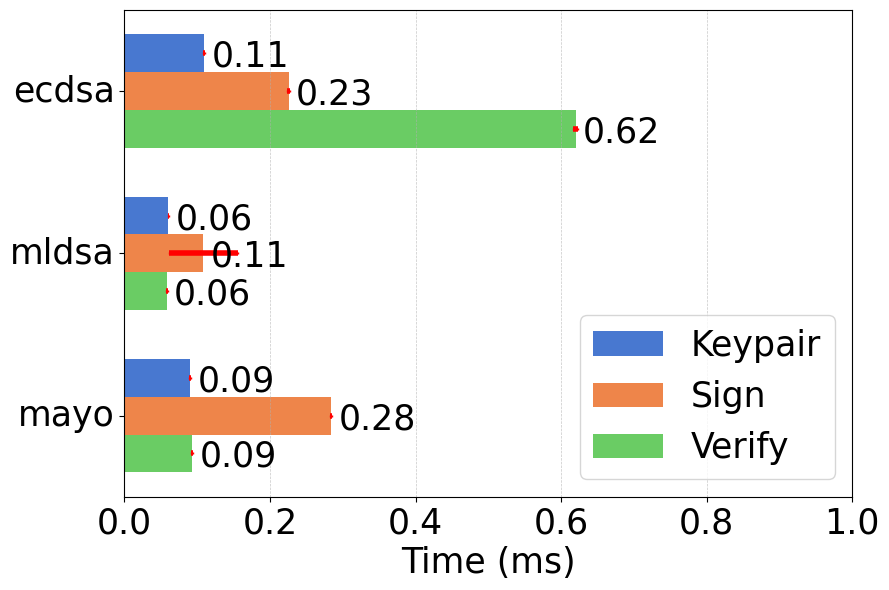

CSV Variants: {'SPHINCS+-SHA2-256f-simple', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-192s-simple', 'cross-rsdp-128-balanced', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-128-fast', 'cross-rsdp-256-balanced', 'ML-DSA-87', 'MAYO-5', 'P-521', 'MAYO-2', 'SPHINCS+-SHAKE-128f-simple', 'MAYO-3', 'cross-rsdpg-256-balanced', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdp-128-small', 'Falcon-1024', 'Falcon-512', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdpg-256-small', 'ML-DSA-65', 'SPHINCS+-SHA2-128f-simple', 'cross-rsdpg-192-small', 'cross-rsdp-192-small', 'P-384', 'cross-rsdp-256-fast', 'cross-rsdp-192-fast', 'cross-rsdpg-256-fast', 'cross-rsdp-256-small', 'ML-DSA-44', 'cross-rsdpg-128-fast', 'P-256', 'SPHINCS+-SHAKE-192f-simple', 'cross-rsdp-192-balanced', 'SPHINCS+-SHA2-192s-simple', 'SPHINCS+-SHA2-128s-simple', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdpg-192-balanced', 'cross-rsdpg-128-small', 'SPHINCS+-SHA2-192f-simple', 'cross-rsdpg-192-fast'}
Variants by level: {1: [{'algorithm': 'ecdsa', 'varia

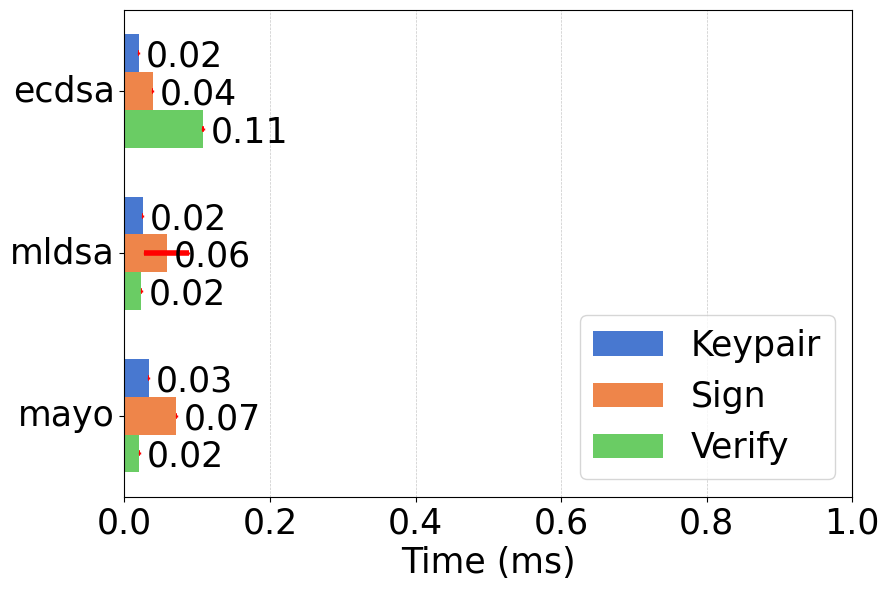

	Processing level 3 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-384'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-65'}, {'algorithm': 'mayo', 'variant': 'MAYO-3'}]
Variant to Algorithm mapping: {'P-384': 'ecdsa', 'ML-DSA-65': 'mldsa', 'MAYO-3': 'mayo'}

DataFrame with algorithm column:
            mean_keypair  std_keypair  mean_sign  std_sign  mean_verify  \
variant                                                                  
MAYO-3         0.063023     0.001175   0.201677  0.001854     0.073161   
ML-DSA-65      0.039386     0.000759   0.091229  0.049952     0.036427   
P-384          0.123114     0.002160   0.200921  0.002610     0.593409   

           std_verify algorithm          algorithm2  
variant                                              
MAYO-3       0.001047      mayo      mayo\n(MAYO-3)  
ML-DSA-65    0.000529     mldsa  mldsa\n(ML-DSA-65)  
P-384        0.004425     ecdsa      ecdsa\n(P-384)  
graficos/m2_level-3.pdf


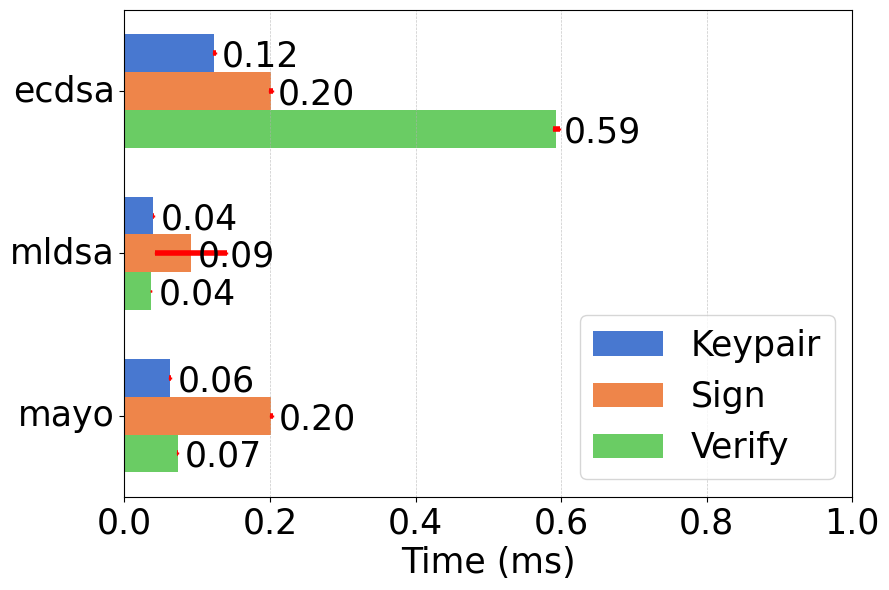

	Processing level 5 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-521'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-87'}, {'algorithm': 'mayo', 'variant': 'MAYO-5'}]
Variant to Algorithm mapping: {'P-521': 'ecdsa', 'ML-DSA-87': 'mldsa', 'MAYO-5': 'mayo'}

DataFrame with algorithm column:
            mean_keypair  std_keypair  mean_sign  std_sign  mean_verify  \
variant                                                                  
MAYO-5         0.136060     0.001666   0.395788  0.003131     0.146737   
ML-DSA-87      0.060862     0.001112   0.114114  0.049606     0.056786   
P-521          0.127226     0.001753   0.253846  0.002497     0.699973   

           std_verify algorithm          algorithm2  
variant                                              
MAYO-5       0.001757      mayo      mayo\n(MAYO-5)  
ML-DSA-87    0.001257     mldsa  mldsa\n(ML-DSA-87)  
P-521        0.004291     ecdsa      ecdsa\n(P-521)  
graficos/m2_level-5.pdf


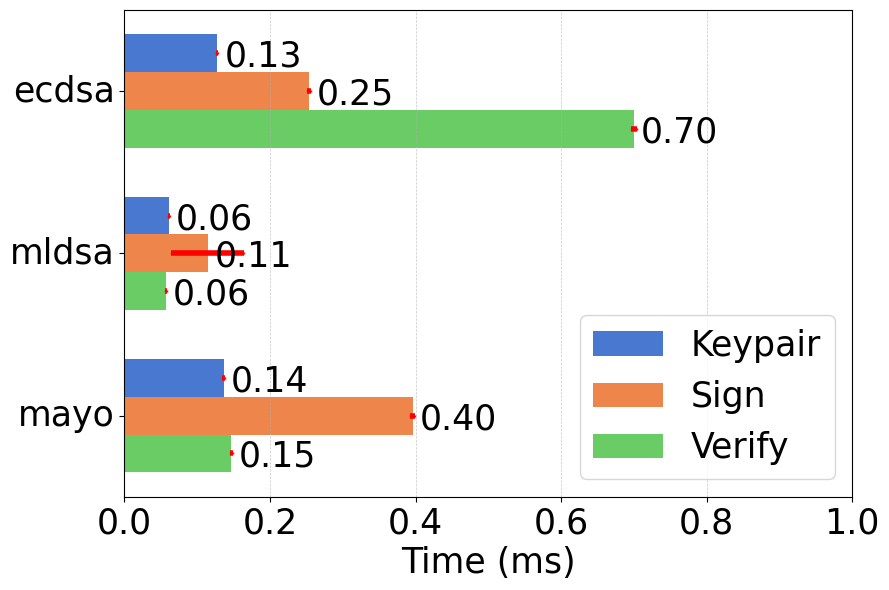

CSV Variants: {'SPHINCS+-SHA2-256f-simple', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-192s-simple', 'cross-rsdp-128-balanced', 'Falcon-padded-1024', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-128-fast', 'cross-rsdp-256-balanced', 'ML-DSA-87', 'MAYO-5', 'P-521', 'MAYO-2', 'SPHINCS+-SHAKE-128f-simple', 'MAYO-3', 'cross-rsdpg-256-balanced', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdp-128-small', 'Falcon-1024', 'Falcon-512', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdpg-256-small', 'ML-DSA-65', 'Dilithium5', 'SPHINCS+-SHA2-128f-simple', 'cross-rsdpg-192-small', 'cross-rsdp-192-small', 'P-384', 'cross-rsdp-256-fast', 'Dilithium2', 'cross-rsdp-192-fast', 'cross-rsdpg-256-fast', 'cross-rsdp-256-small', 'Falcon-padded-512', 'ML-DSA-44', 'cross-rsdpg-128-fast', 'P-256', 'SPHINCS+-SHAKE-192f-simple', 'cross-rsdp-192-balanced', 'SPHINCS+-SHA2-192s-simple', 'Dilithium3', 'SPHINCS+-SHA2-128s-simple', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdpg-192-balanced', 'cross-rsdpg-128-small', 'SPHINCS+-SHA2-192f-s

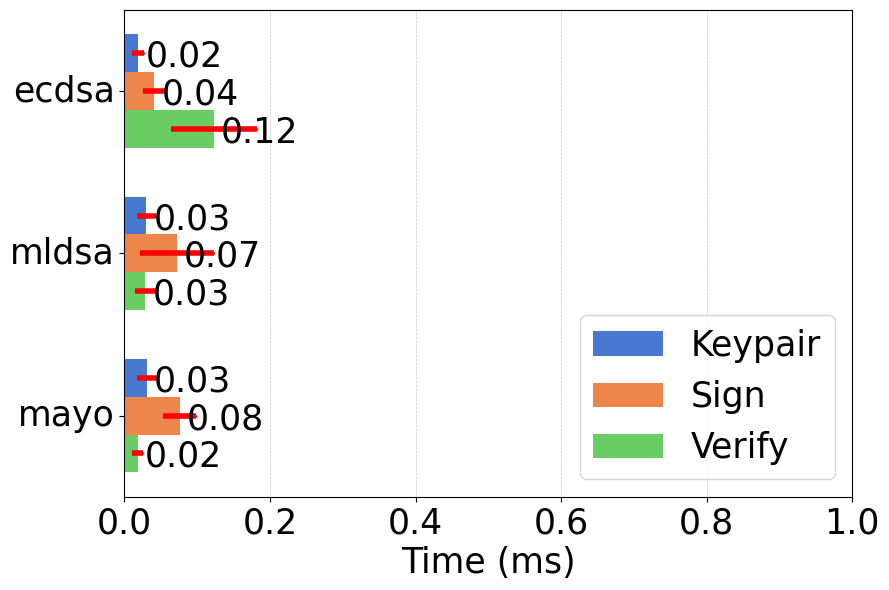

	Processing level 3 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-384'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-65'}, {'algorithm': 'mayo', 'variant': 'MAYO-3'}]
Variant to Algorithm mapping: {'P-384': 'ecdsa', 'ML-DSA-65': 'mldsa', 'MAYO-3': 'mayo'}

DataFrame with algorithm column:
            mean_keypair  std_keypair  mean_sign  std_sign  mean_verify  \
variant                                                                  
MAYO-3         0.052994     0.016406   0.208069  0.037689     0.062426   
ML-DSA-65      0.047078     0.014625   0.110530  0.072413     0.044354   
P-384          0.141421     0.034908   0.232173  0.058601     0.686095   

           std_verify algorithm          algorithm2  
variant                                              
MAYO-3       0.028019      mayo      mayo\n(MAYO-3)  
ML-DSA-65    0.013813     mldsa  mldsa\n(ML-DSA-65)  
P-384        0.154408     ecdsa      ecdsa\n(P-384)  
graficos/m3_level-3.pdf


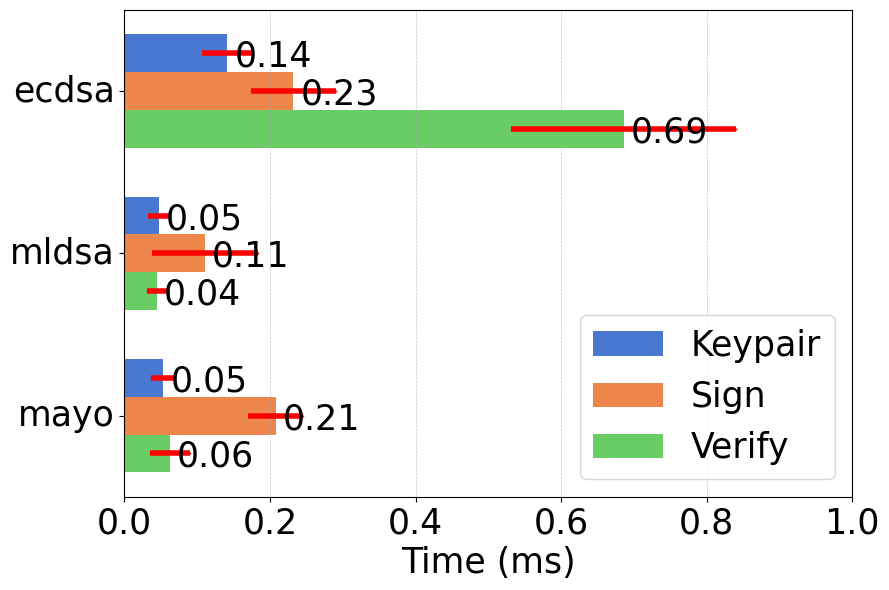

	Processing level 5 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-521'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-87'}, {'algorithm': 'mayo', 'variant': 'MAYO-5'}]
Variant to Algorithm mapping: {'P-521': 'ecdsa', 'ML-DSA-87': 'mldsa', 'MAYO-5': 'mayo'}

DataFrame with algorithm column:
            mean_keypair  std_keypair  mean_sign  std_sign  mean_verify  \
variant                                                                  
MAYO-5         0.112868     0.023178   0.398720  0.060200     0.118089   
ML-DSA-87      0.071287     0.017648   0.132170  0.062728     0.067849   
P-521          0.144446     0.046304   0.299668  0.064228     0.819189   

           std_verify algorithm          algorithm2  
variant                                              
MAYO-5       0.020997      mayo      mayo\n(MAYO-5)  
ML-DSA-87    0.026751     mldsa  mldsa\n(ML-DSA-87)  
P-521        0.138191     ecdsa      ecdsa\n(P-521)  
graficos/m3_level-5.pdf


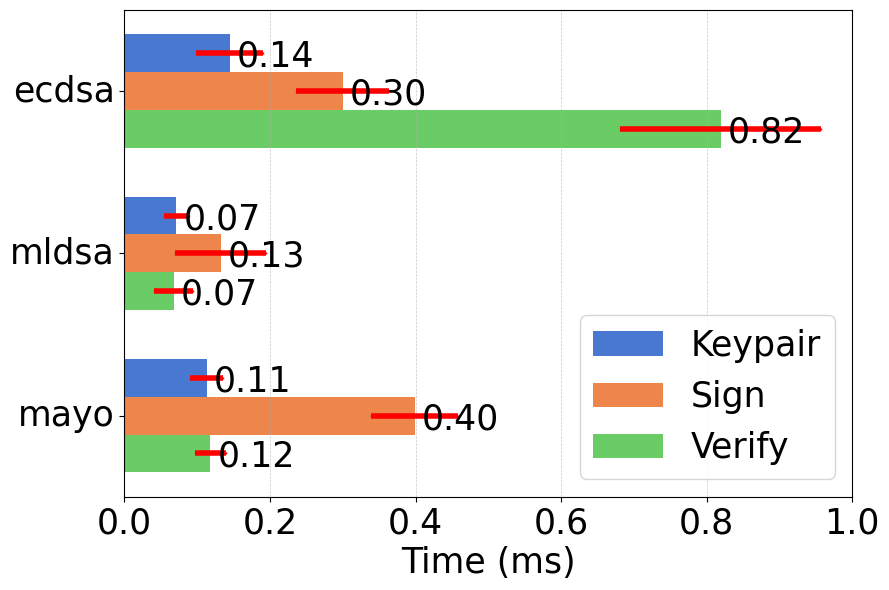

In [243]:
def plot_horizontal_multiple(
    dfs,                # lista de DataFrames
    columns,
    graphics_directory,
    values_offset,
    error_offset,
    levels=None,        # lista de níveis (opcional)
    xscale="linear",
    xlabel=None,
    xlim=None,
    xticks=None,
    yticklabels="variant",
    figsize=None,
    width=0.7,
    titles=None,        # lista de títulos (opcional)
    ylabel=None,
    show_graph=False,
    show_values=True,
    show_errors=True,
    show_legend=True,
    save_formats=("pdf", "png"),
    file_name="multiples",     # nome do arquivo para salvar os gráficos (opcional)
    pallet_start = 0,
):
    """
    Plota múltiplos gráficos horizontais em uma única figura, um para cada DataFrame da lista.
    """
    n_plots = len(dfs)
    fig, axes = plt.subplots(1, 1, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    fontsize = 25
    for idx, df in enumerate(dfs):
        n_variants = len(df)
        n_columns = len(columns)
        width_bar = width / n_columns
        y = np.arange(n_variants)
        ax = axes[idx]
        palette = sns.color_palette("muted", n_colors=10)
        
         
        for i, (val_col, err_col, label) in enumerate(columns):
            color=palette[i+pallet_start]
             
            
            values = df[val_col]
            errors = df[err_col]
            reverse_i = n_columns - 1 - i

            bars = ax.barh(
                y + (reverse_i - (n_columns - 1) / 2) * width_bar,
                values,
                height=width_bar,
                xerr=errors if show_errors else None,
                label=label,
                color=color,
                error_kw={"capsize": 1, "ecolor": "red", "elinewidth": 4}
            )

            if show_values:
                
                for bar, value in zip(bars, values):
                     
                    if value == 0 :
                        if   label == "Sign":
                            print("N/A detected, adding text counter:", label)
                            ax.text(
                                    0.1,
                                    bar.get_y() +0.13,
                                    f"N/A",
                                    va="center_baseline",
                                    ha="right",
                                    fontsize=fontsize,
                                    color="black",
                                    # fontweight="bold",
                                )
                    else:
                        ax.text(
                            value + values_offset,
                            bar.get_y() + bar.get_height() / 2,
                            f"{value:.2f}",
                            va="center_baseline",
                            ha="left",
                            fontsize=fontsize,
                            color="black",
                            # fontweight="bold",
                        )

            # if show_errors:
            #     for bar, value, error in zip(bars, values, errors):
            #         right = value + error
            #         if value < 0.05:
            #             right += 0.05

                     
            #         if value != 0:
            #             ax.text(
            #                 right * error_offset ,
            #                 bar.get_y() + bar.get_height() / 2,
            #                 f"±{error:.2f}",
            #                 va="center_baseline",
            #                 ha="left",
            #                 fontsize=fontsize,
            #                 color="red",
            #             )

        ax.set_yticks(y)
        ax.set_yticklabels(df[yticklabels].to_list(), rotation=0, va="center")

        if ylabel:
            ax.set_ylabel(ylabel, fontsize=fontsize)
        if xlabel:
            ax.set_xlabel(xlabel, fontsize=fontsize)
        if titles and idx < len(titles):
            ax.set_title(titles[idx], fontsize=fontsize)
        # elif levels and idx < len(levels):
        #     ax.set_title(f"Level {levels[idx]}", fontsize=fontsize)

        ax.set_xscale(xscale)
        if xscale == "log" and xticks is not None:
            ax.set_xticks(xticks)
        if xscale == "linear" and xlim:
            ax.set_xlim(*xlim)
        ax.set_ylim(y[0] - 0.5, y[-1] + 0.5)
        ax.tick_params(axis="y", labelsize=fontsize)
        ax.tick_params(axis="x", labelsize=fontsize)
        if show_legend:
            ax.legend(loc="lower right", fontsize=fontsize)
        ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    

     
    for ext in save_formats:
        file = f"{graphics_directory}/{file_name}.{ext}"
        plt.savefig(file, format=ext)
        print(file)

    
    plt.show()
    plt.close()

 
    # if show_graph:
    #     plt.show()
    # else:
    #     plt.close()




# Example usage:
# results = load_results("resultados-artigo")

all_algorithms = load_algorithms("algorithms")
levels = [1, 3, 5]
sign = """ecdsa
    mldsa
    sphincs-sha-s
    sphincs-sha-f
    sphincs-shake-s
    sphincs-shake-f
    falcon
    mayo
    cross-rsdp-small
    cross-rsdpg-small
    cross-rsdp-balanced
    cross-rsdpg-balanced
    cross-rsdp-fast
    cross-rsdpg-fast"""

# sign = """ecdsa
#     mldsa
#     falcon
#     mayo
#     """

sign = """mayo
    mldsa
    ecdsa
    """
sign_list = [s.strip() for s in sign.split()]

print("All algorithms loaded:", list(all_algorithms.keys()))
filtered_algorithms = filter_algorithms(all_algorithms, sign_list, levels)
print("Filtered algorithms:", filtered_algorithms)
combined_mechanisms = {}
for algorithm in filtered_algorithms.values():
    combined_mechanisms.update(algorithm)

print("Combined mechanisms:", combined_mechanisms)

columns = [
         ("mean_keypair", "std_keypair", "Keypair")
        ,("mean_sign", "std_sign", "Sign")
        ,("mean_verify", "std_verify", "Verify"),
    ]

for m in ["m1", "m2", "m3"]:
    df_ethereum = results[m]["time-evaluation-mean-std"]
    variants_by_level = get_variants_by_level(df_ethereum, combined_mechanisms)
    print("Variants by level:", variants_by_level)
    dfs = []
    
    for level, variants in variants_by_level.items():
        print(f"\tProcessing level {level} with variants: {variants}")
        variant_to_algorithm = {v["variant"]: v["algorithm"] for v in variants}
        print("Variant to Algorithm mapping:", variant_to_algorithm)
        variant_names = [v["variant"] for v in variants]
        
        df_ethereum_subset = df_ethereum.loc[variant_names].copy()  # Explicit copy to avoid SettingWithCopyWarning
        
        # Map algorithm names
        df_ethereum_subset["algorithm"] = df_ethereum_subset.index.map(variant_to_algorithm)
        
        # Add missing algorithms BEFORE creating algorithm2
        for s in sign_list:
            if s not in df_ethereum_subset["algorithm"].values:
                new_row = {col: 0.000000000000 for col in df_ethereum_subset.columns}
                new_row["algorithm"] = s
                new_row["variant"] = f"N/A-{s}"
                new_row_df = pd.DataFrame([new_row]).set_index("variant")
                df_ethereum_subset = pd.concat([df_ethereum_subset, new_row_df])
        
        # Now create algorithm2 after all rows exist
        df_ethereum_subset["algorithm2"] = df_ethereum_subset.apply(
            lambda x: f"{x['algorithm']}\n({x.name})" if "N/A" not in str(x.name) 
                     else x['algorithm'],
            axis=1
        )
        
        # Sort and categorize
        df_ethereum_subset["algorithm"] = pd.Categorical(
            df_ethereum_subset["algorithm"], 
            categories=sign_list, 
            ordered=True
        )
        df_ethereum_subset = df_ethereum_subset.sort_values("algorithm")
        
        print("\nDataFrame with algorithm column:\n", df_ethereum_subset)
        # dfs.append(df_subset)

        # plot_time_evaluation_horizontal_multiple(
        #     [df_subset], 
        #     graphics_directory=OUTPUT_DIR, 
        #     show_graph=True, 
        #     columns=columns,
        #     figsize=(9, 6),
        #     xlim=(0, 1),
        #     file_name=f"{m}_level-{level}"
        # )
        xscale = "linear"
        xlabel = "Time (ms)"
        
        xticks = None
        # yticklabels = "variant" if "variant" in df.columns else df.index.name
        yticklabels = "algorithm"  # if "variant" in df.columns else df.index.name

        width = 0.7
        title = None
        ylabel = None
        save_formats = ["pdf"]
 

        plot_horizontal_multiple(
            dfs=[df_ethereum_subset],
            columns=columns,
            graphics_directory=OUTPUT_DIR,
            values_offset=0.01,
            error_offset=0,
            xscale=xscale,
            xlabel=xlabel,
            # xlim=log_xlim,
            # xticks=log_xticks,
            yticklabels=yticklabels,
            figsize=(9,6),
            width=width,
            xlim=(0,1),
            ylabel=ylabel,
            show_graph=True,
            show_values=True,
            show_errors=True,
            show_legend=True,
            save_formats=save_formats,
            file_name=f"{m}_level-{level}"
           
        )


All algorithms loaded: ['cryptography', 'liboqs']
Filtered algorithms: {'cryptography': {'ecdsa': {1: 'P-256', 3: 'P-384', 5: 'P-521'}}, 'liboqs': {'mldsa': {1: 'ML-DSA-44', 3: 'ML-DSA-65', 5: 'ML-DSA-87'}, 'mayo': {1: 'MAYO-2', 3: 'MAYO-3', 5: 'MAYO-5'}}}
Combined mechanisms: {'ecdsa': {1: 'P-256', 3: 'P-384', 5: 'P-521'}, 'mldsa': {1: 'ML-DSA-44', 3: 'ML-DSA-65', 5: 'ML-DSA-87'}, 'mayo': {1: 'MAYO-2', 3: 'MAYO-3', 5: 'MAYO-5'}}
CSV Variants: {'SPHINCS+-SHA2-256f-simple', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-192s-simple', 'cross-rsdp-128-balanced', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-128-fast', 'cross-rsdp-256-balanced', 'ML-DSA-87', 'MAYO-5', 'P-521', 'MAYO-2', 'SPHINCS+-SHAKE-128f-simple', 'MAYO-3', 'cross-rsdpg-256-balanced', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdp-128-small', 'Falcon-1024', 'Falcon-512', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdpg-256-small', 'ML-DSA-65', 'SPHINCS+-SHA2-128f-simple', 'cross-rsdpg-192-small', 'cross-rsdp-192-small', 'P-384', 'cross-rs

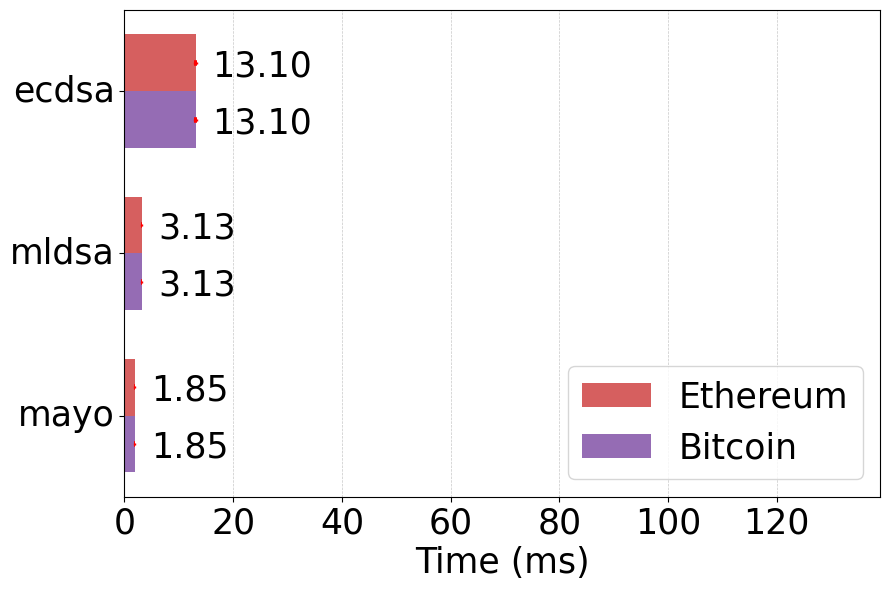

	Processing level 3 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-384'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-65'}, {'algorithm': 'mayo', 'variant': 'MAYO-3'}]
Variant to Algorithm mapping: {'P-384': 'ecdsa', 'ML-DSA-65': 'mldsa', 'MAYO-3': 'mayo'}

DataFrame with algorithm column:
            mean_verify  std_verify  Bitcoin_mean_verify  Bitcoin_std_verify  \
variant                                                                       
MAYO-3        6.722640    0.117995             6.722640            0.117995   
ML-DSA-65     5.124417    0.092669             5.124417            0.092669   
P-384        83.191493    1.485953            83.191493            1.485953   

          algorithm          algorithm2  
variant                                  
MAYO-3         mayo      mayo\n(MAYO-3)  
ML-DSA-65     mldsa  mldsa\n(ML-DSA-65)  
P-384         ecdsa      ecdsa\n(P-384)  
           mean_verify  std_verify  Bitcoin_mean_verify  Bitcoin_std_verify  \
variant            

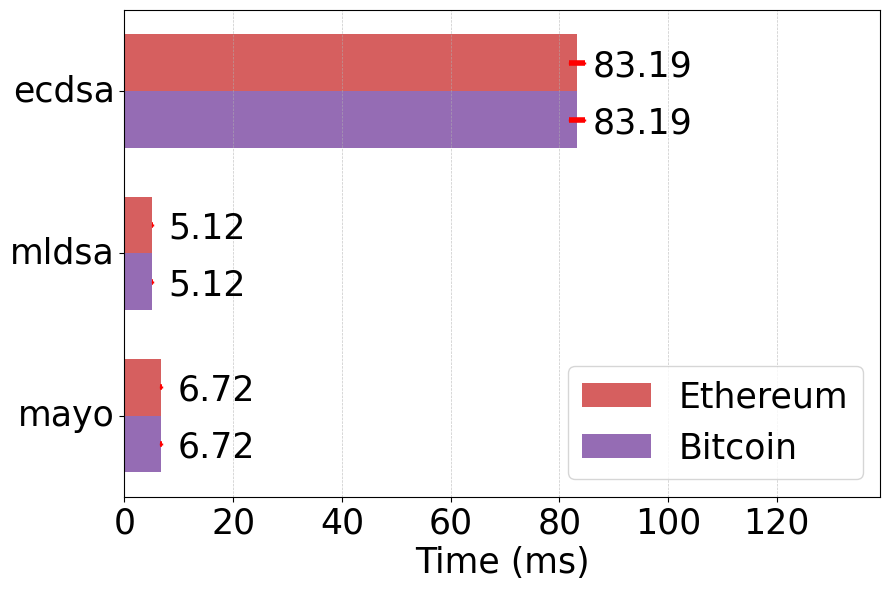

	Processing level 5 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-521'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-87'}, {'algorithm': 'mayo', 'variant': 'MAYO-5'}]
Variant to Algorithm mapping: {'P-521': 'ecdsa', 'ML-DSA-87': 'mldsa', 'MAYO-5': 'mayo'}

DataFrame with algorithm column:
            mean_verify  std_verify  Bitcoin_mean_verify  Bitcoin_std_verify  \
variant                                                                       
MAYO-5       12.813098    0.229678            12.813098            0.229678   
ML-DSA-87     8.047120    0.144677             8.047120            0.144677   
P-521        85.513790    1.502669            85.513790            1.502669   

          algorithm          algorithm2  
variant                                  
MAYO-5         mayo      mayo\n(MAYO-5)  
ML-DSA-87     mldsa  mldsa\n(ML-DSA-87)  
P-521         ecdsa      ecdsa\n(P-521)  
           mean_verify  std_verify  Bitcoin_mean_verify  Bitcoin_std_verify  \
variant            

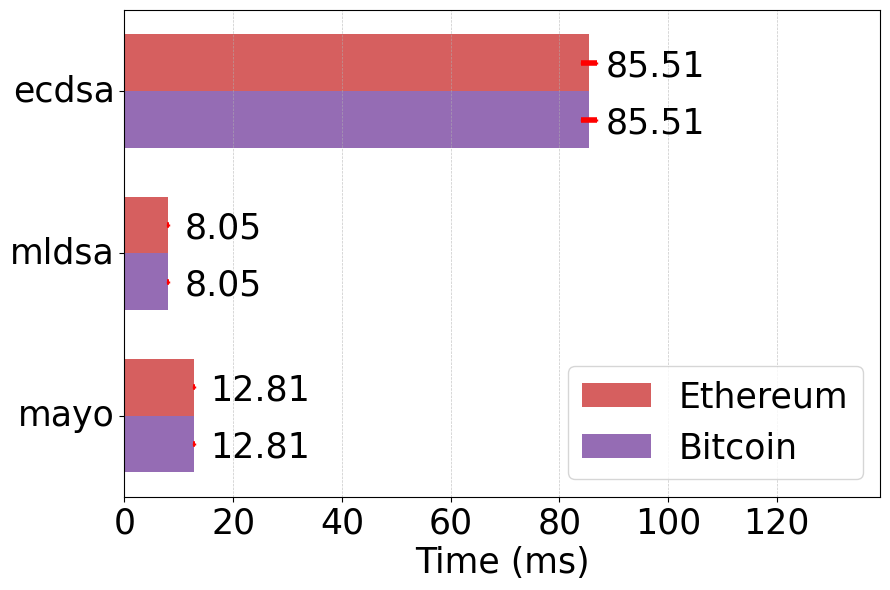

CSV Variants: {'SPHINCS+-SHA2-256f-simple', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-192s-simple', 'cross-rsdp-128-balanced', 'Falcon-padded-1024', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-128-fast', 'cross-rsdp-256-balanced', 'ML-DSA-87', 'MAYO-5', 'P-521', 'MAYO-2', 'SPHINCS+-SHAKE-128f-simple', 'MAYO-3', 'cross-rsdpg-256-balanced', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdp-128-small', 'Falcon-1024', 'Falcon-512', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdpg-256-small', 'ML-DSA-65', 'Dilithium5', 'SPHINCS+-SHA2-128f-simple', 'cross-rsdpg-192-small', 'cross-rsdp-192-small', 'P-384', 'cross-rsdp-256-fast', 'Dilithium2', 'cross-rsdp-192-fast', 'cross-rsdpg-256-fast', 'cross-rsdp-256-small', 'Falcon-padded-512', 'ML-DSA-44', 'cross-rsdpg-128-fast', 'P-256', 'SPHINCS+-SHAKE-192f-simple', 'cross-rsdp-192-balanced', 'SPHINCS+-SHA2-192s-simple', 'Dilithium3', 'SPHINCS+-SHA2-128s-simple', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdpg-192-balanced', 'cross-rsdpg-128-small', 'SPHINCS+-SHA2-192f-s

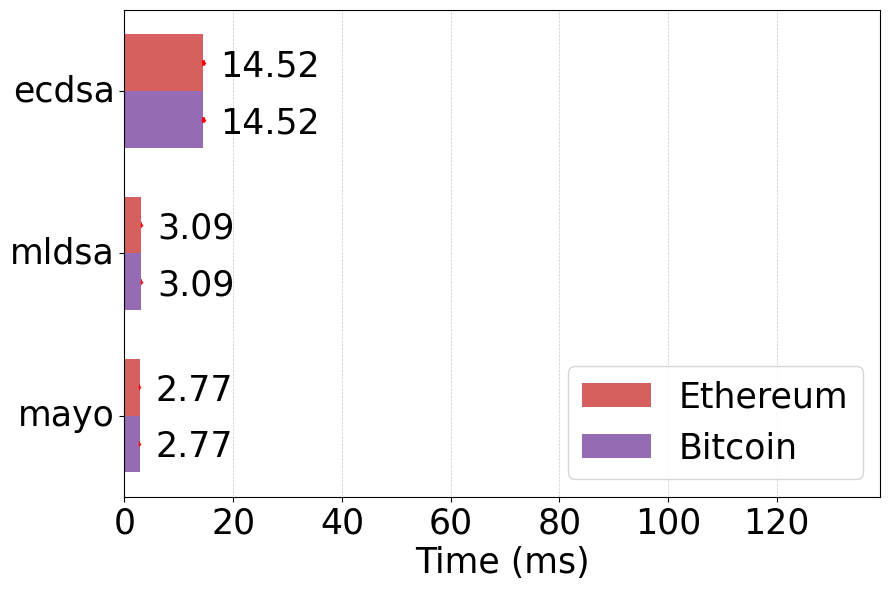

	Processing level 3 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-384'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-65'}, {'algorithm': 'mayo', 'variant': 'MAYO-3'}]
Variant to Algorithm mapping: {'P-384': 'ecdsa', 'ML-DSA-65': 'mldsa', 'MAYO-3': 'mayo'}

DataFrame with algorithm column:
            mean_verify  std_verify  Bitcoin_mean_verify  Bitcoin_std_verify  \
variant                                                                       
MAYO-3        9.831989    0.206010             9.831989            0.206010   
ML-DSA-65     4.891757    0.103349             4.891757            0.103349   
P-384        79.629011    1.745513            79.629011            1.745513   

          algorithm          algorithm2  
variant                                  
MAYO-3         mayo      mayo\n(MAYO-3)  
ML-DSA-65     mldsa  mldsa\n(ML-DSA-65)  
P-384         ecdsa      ecdsa\n(P-384)  
           mean_verify  std_verify  Bitcoin_mean_verify  Bitcoin_std_verify  \
variant            

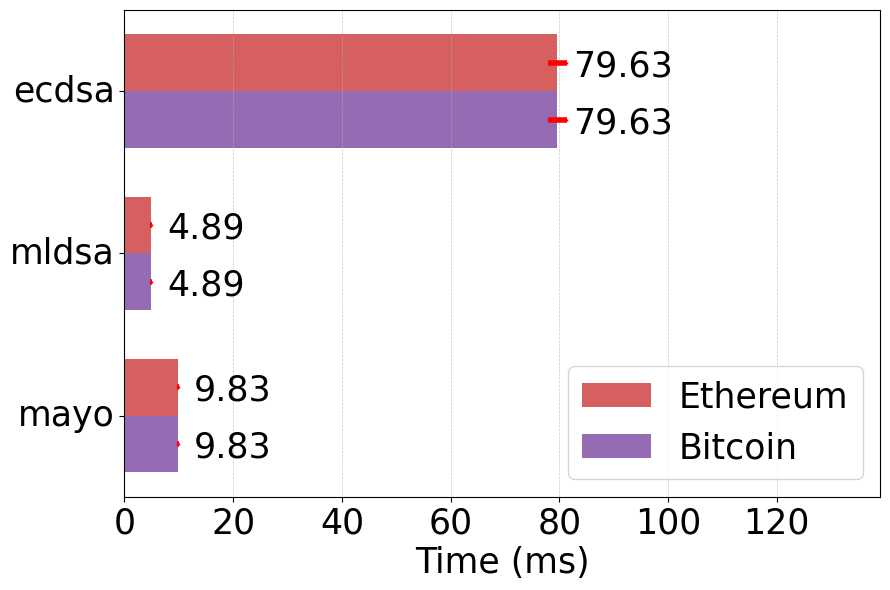

	Processing level 5 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-521'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-87'}, {'algorithm': 'mayo', 'variant': 'MAYO-5'}]
Variant to Algorithm mapping: {'P-521': 'ecdsa', 'ML-DSA-87': 'mldsa', 'MAYO-5': 'mayo'}

DataFrame with algorithm column:
            mean_verify  std_verify  Bitcoin_mean_verify  Bitcoin_std_verify  \
variant                                                                       
MAYO-5       19.684271    0.441626            19.684271            0.441626   
ML-DSA-87     7.628743    0.168949             7.628743            0.168949   
P-521        94.045413    2.038804            94.045413            2.038804   

          algorithm          algorithm2  
variant                                  
MAYO-5         mayo      mayo\n(MAYO-5)  
ML-DSA-87     mldsa  mldsa\n(ML-DSA-87)  
P-521         ecdsa      ecdsa\n(P-521)  
           mean_verify  std_verify  Bitcoin_mean_verify  Bitcoin_std_verify  \
variant            

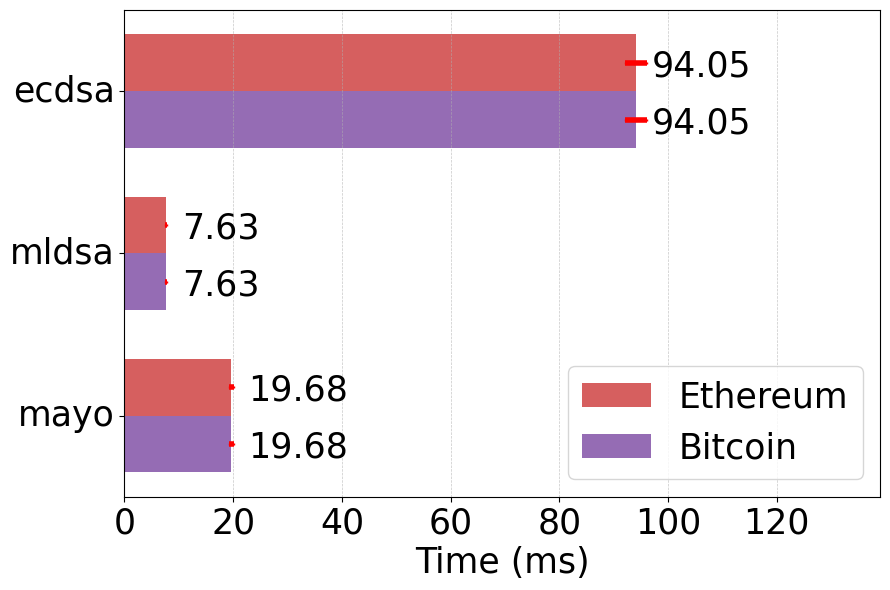

CSV Variants: {'SPHINCS+-SHA2-256f-simple', 'cross-rsdpg-128-balanced', 'SPHINCS+-SHAKE-192s-simple', 'cross-rsdp-128-balanced', 'SPHINCS+-SHAKE-256f-simple', 'cross-rsdp-128-fast', 'cross-rsdp-256-balanced', 'ML-DSA-87', 'MAYO-5', 'P-521', 'MAYO-2', 'SPHINCS+-SHAKE-128f-simple', 'MAYO-3', 'cross-rsdpg-256-balanced', 'SPHINCS+-SHAKE-128s-simple', 'cross-rsdp-128-small', 'Falcon-1024', 'Falcon-512', 'SPHINCS+-SHAKE-256s-simple', 'cross-rsdpg-256-small', 'ML-DSA-65', 'SPHINCS+-SHA2-128f-simple', 'cross-rsdpg-192-small', 'cross-rsdp-192-small', 'P-384', 'cross-rsdp-256-fast', 'cross-rsdp-192-fast', 'cross-rsdpg-256-fast', 'cross-rsdp-256-small', 'cross-rsdpg-128-fast', 'P-256', 'SPHINCS+-SHAKE-192f-simple', 'cross-rsdp-192-balanced', 'SPHINCS+-SHA2-192s-simple', 'SPHINCS+-SHA2-128s-simple', 'SPHINCS+-SHA2-256s-simple', 'cross-rsdpg-192-balanced', 'cross-rsdpg-128-small', 'SPHINCS+-SHA2-192f-simple', 'cross-rsdpg-192-fast'}
Variants by level: {1: [{'algorithm': 'ecdsa', 'variant': 'P-256'}

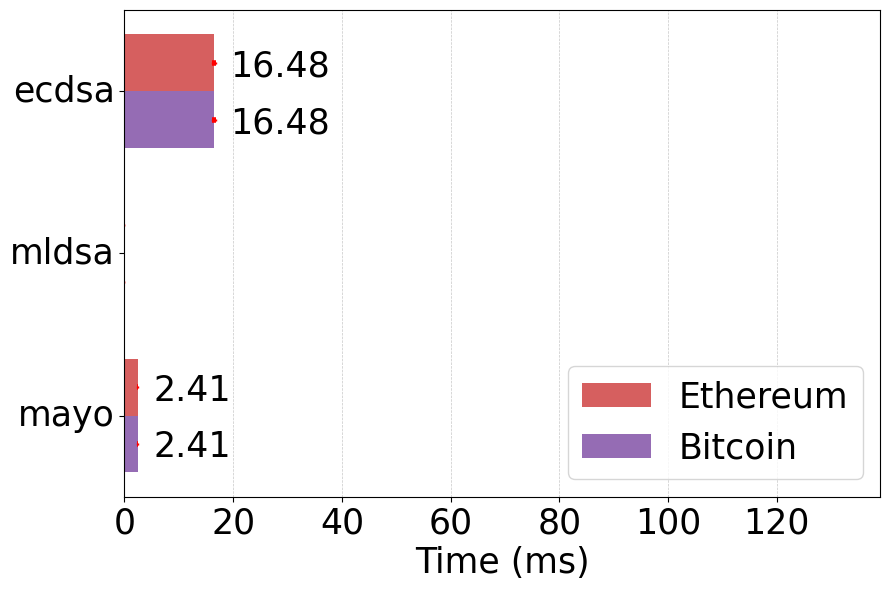

	Processing level 3 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-384'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-65'}, {'algorithm': 'mayo', 'variant': 'MAYO-3'}]
Variant to Algorithm mapping: {'P-384': 'ecdsa', 'ML-DSA-65': 'mldsa', 'MAYO-3': 'mayo'}

DataFrame with algorithm column:
            Unnamed: 0  mean_verify  std_verify  Bitcoin_mean_verify  \
variant                                                               
MAYO-3              3     8.395961    0.176493             8.395961   
ML-DSA-65           5     5.964936    0.117969             5.964936   
P-384               8    92.351587    1.823862            92.351587   

           Bitcoin_std_verify algorithm          algorithm2  
variant                                                      
MAYO-3               0.176493      mayo      mayo\n(MAYO-3)  
ML-DSA-65            0.117969     mldsa  mldsa\n(ML-DSA-65)  
P-384                1.823862     ecdsa      ecdsa\n(P-384)  
           Unnamed: 0  mean_verify  st

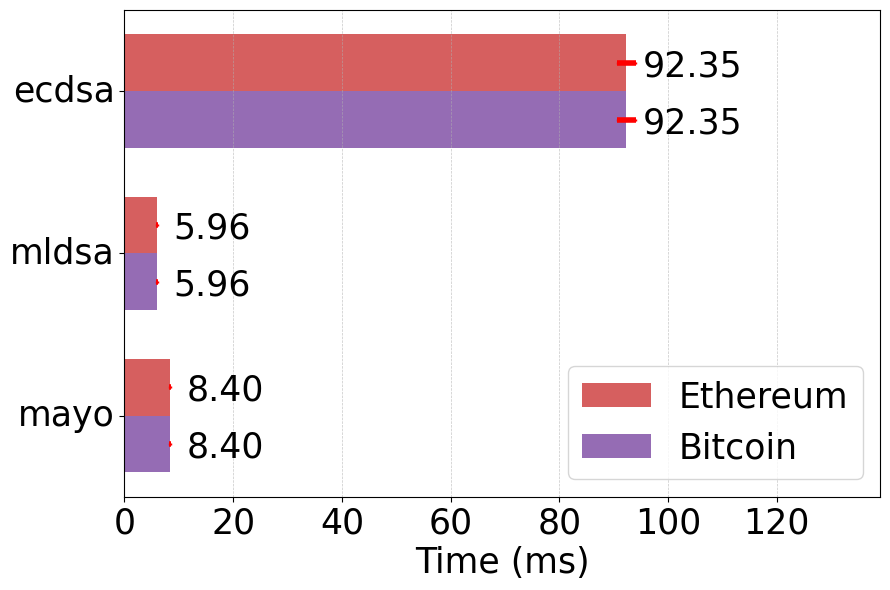

	Processing level 5 with variants: [{'algorithm': 'ecdsa', 'variant': 'P-521'}, {'algorithm': 'mldsa', 'variant': 'ML-DSA-87'}, {'algorithm': 'mayo', 'variant': 'MAYO-5'}]
Variant to Algorithm mapping: {'P-521': 'ecdsa', 'ML-DSA-87': 'mldsa', 'MAYO-5': 'mayo'}

DataFrame with algorithm column:
            Unnamed: 0  mean_verify  std_verify  Bitcoin_mean_verify  \
variant                                                               
MAYO-5              4    15.892652    0.315360            15.892652   
ML-DSA-87           6     9.131835    0.187986             9.131835   
P-521               9   110.155319    2.083182           110.155319   

           Bitcoin_std_verify algorithm          algorithm2  
variant                                                      
MAYO-5               0.315360      mayo      mayo\n(MAYO-5)  
ML-DSA-87            0.187986     mldsa  mldsa\n(ML-DSA-87)  
P-521                2.083182     ecdsa      ecdsa\n(P-521)  
           Unnamed: 0  mean_verify  st

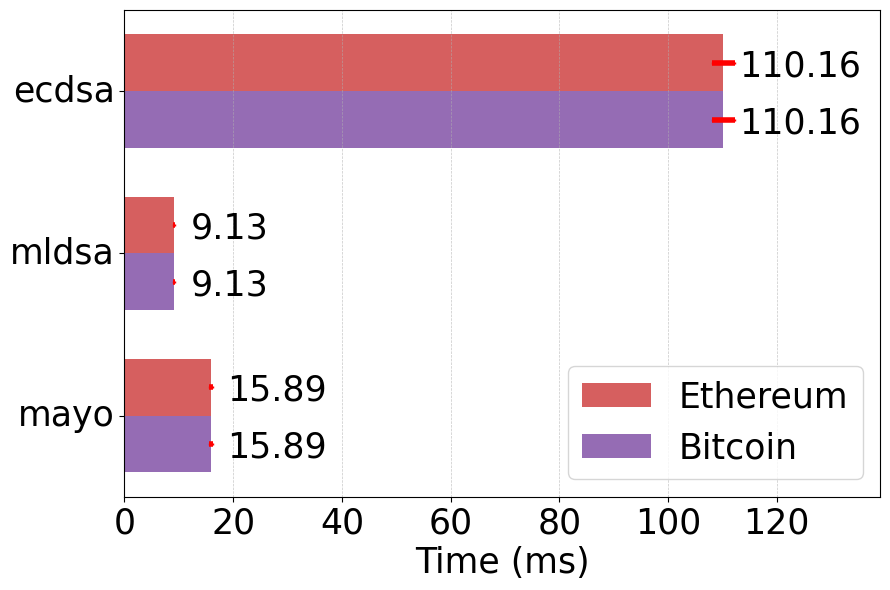

In [244]:
all_algorithms = load_algorithms("algorithms")
levels = [1, 3, 5]

sign = """mayo
    mldsa
    ecdsa
    """
sign_list = [s.strip() for s in sign.split()]

print("All algorithms loaded:", list(all_algorithms.keys()))
filtered_algorithms = filter_algorithms(all_algorithms, sign_list, levels)
print("Filtered algorithms:", filtered_algorithms)
combined_mechanisms = {}
for algorithm in filtered_algorithms.values():
    combined_mechanisms.update(algorithm)

print("Combined mechanisms:", combined_mechanisms)

columns = [
        # ("mean_keypair", "std_keypair", "Keypair"),
        # ("mean_sign", "std_sign", "Sign"),
        ("mean_verify", "std_verify", "Ethereum"),
        ("Bitcoin_mean_verify", "Bitcoin_std_verify", "Bitcoin"),
    ]

for m in ["m1", "m2", "m3"]:
    df_ethereum = results[m]["blocksim-mean-std"]
    df_bitcoin = results[m]["blocksim-mean-std"]
    variants_by_level = get_variants_by_level(df_ethereum, combined_mechanisms)
    print("Variants by level:", variants_by_level)
    dfs = []
    
    for level, variants in variants_by_level.items():
        print(f"\tProcessing level {level} with variants: {variants}")
        variant_to_algorithm = {v["variant"]: v["algorithm"] for v in variants}
        print("Variant to Algorithm mapping:", variant_to_algorithm)
        variant_names = [v["variant"] for v in variants]
        
        df_ethereum_subset = df_ethereum.loc[variant_names].copy()  # Explicit copy to avoid SettingWithCopyWarning
        df_bitcoin_subset = df_bitcoin.loc[variant_names].copy()

        # Map algorithm names
        df_ethereum_subset["algorithm"] = df_ethereum_subset.index.map(variant_to_algorithm)
        
        # Add missing algorithms BEFORE creating algorithm2
        for s in sign_list:
            if s not in df_ethereum_subset["algorithm"].values:
                new_row = {col: 0.000000000000 for col in df_ethereum_subset.columns}
                new_row["algorithm"] = s
                new_row["variant"] = f"N/A-{s}"
                new_row_df = pd.DataFrame([new_row]).set_index("variant")
                df_ethereum_subset = pd.concat([df_ethereum_subset, new_row_df])
         
        # Now create algorithm2 after all rows exist
        df_ethereum_subset["algorithm2"] = df_ethereum_subset.apply(
            lambda x: f"{x['algorithm']}\n({x.name})" if "N/A" not in str(x.name) 
                     else x['algorithm'],
            axis=1
        )
        
        df_ethereum["Bitcoin_mean_verify"] = df_bitcoin["mean_verify"]
        df_ethereum["Bitcoin_std_verify"] = df_bitcoin["std_verify"]
         

        # Sort and categorize
        df_ethereum_subset["algorithm"] = pd.Categorical(
            df_ethereum_subset["algorithm"], 
            categories=sign_list, 
            ordered=True
        )
        df_ethereum_subset = df_ethereum_subset.sort_values("algorithm")
        
        print("\nDataFrame with algorithm column:\n", df_ethereum_subset)
        #dfs.append(df_subset)

        xscale = "linear"
        xlabel = "Time (ms)"
        
        xticks = None
        # yticklabels = "variant" if "variant" in df.columns else df.index.name
        yticklabels = "algorithm"  # if "variant" in df.columns else df.index.name

        width = 0.7
         
        ylabel = None
        save_formats = ["pdf"]
        print(df_ethereum_subset)
         
        #log_xticks=np.logspace(-3, 4, num=8, base=10) 
        #log_xlim=(1e-3, 1e3) 

        plot_horizontal_multiple(
            dfs=[df_ethereum_subset],
            columns=columns,
            graphics_directory=OUTPUT_DIR,
            values_offset=3,
            error_offset=0,
            levels=levels,
            figsize=(9, 6),
            # levels=levels,
            xscale=xscale,
            xlabel=xlabel,
            xlim=(0, 139),
            yticklabels=yticklabels,
            width=width,
            titles=None,
            ylabel=ylabel,
            show_graph=True,
            show_values=True,
            show_errors=True,
            show_legend=True,
             
            save_formats=save_formats,
            file_name=f"sim_{m}_level-{level}",
            pallet_start=3
        )

         